Image Colorization Using AutoEncoder
===
https://medium.freecodecamp.org/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d


In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Read Data
---

In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '.\\images\Vincent_van_Gogh\\'

train_ids = next(os.walk(TRAIN_PATH))[2]

In [5]:
%%time
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.

print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 877/877 [03:44<00:00,  3.74it/s]


Total missing: 86
Wall time: 3min 45s


In [6]:
m_size = X_train.shape[0]
print(m_size)

791


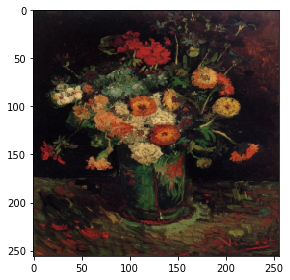

In [7]:
imshow(X_train[3])
plt.show()

Train/Test split
---

In [8]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

Create Model
---

In [13]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('.\\inception-resnet-v2-weights\\inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

In [8]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=2)(encoder_input)
#    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=2)(encoder_output)
#    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=2)(encoder_output)
#    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 256, 256, 128 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 262272      max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_206

In [15]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch
        

Wall time: 0 ns


In [10]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "Art_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

In [11]:
%%time
BATCH_SIZE = 20
model.fit_generator(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=1000,
            verbose=1,
            steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
             callbacks=model_callbacks
                   )

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
39/38 [==============================] - ETA: 55:34 - loss: 0.02 - ETA: 42:45 - loss: 0.45 - ETA: 39:10 - loss: 0.58 - ETA: 36:01 - loss: 0.46 - ETA: 34:20 - loss: 0.37 - ETA: 32:17 - loss: 0.31 - ETA: 31:21 - loss: 0.27 - ETA: 29:49 - loss: 0.24 - ETA: 28:35 - loss: 0.21 - ETA: 27:45 - loss: 0.19 - ETA: 26:15 - loss: 0.17 - ETA: 25:30 - loss: 0.16 - ETA: 24:22 - loss: 0.15 - ETA: 23:16 - loss: 0.14 - ETA: 22:18 - loss: 0.13 - ETA: 21:12 - loss: 0.13 - ETA: 20:05 - loss: 0.12 - ETA: 19:00 - loss: 0.11 - ETA: 17:55 - loss: 0.11 - ETA: 16:54 - loss: 0.10 - ETA: 15:52 - loss: 0.10 - ETA: 14:55 - loss: 0.09 - ETA: 13:54 - loss: 0.09 - ETA: 12:59 - loss: 0.09 - ETA: 12:01 - loss: 0.08 - ETA: 11:06 - loss: 0.08 - ETA: 10:09 - loss: 0.08 - ETA: 9:13 - loss: 0.0814 - ETA: 8:17 - loss: 0.079 - ETA: 7:24 - loss: 0.077 - ETA: 6:30 - loss: 0.075 - ETA: 5:38 - loss: 0.073 - ETA: 4:45 - loss: 0.071 - ETA: 3:53 - loss: 0.069 - ETA: 3:01 - los

39/38 [==============================] - ETA: 30:22 - loss: 0.01 - ETA: 28:50 - loss: 0.01 - ETA: 27:50 - loss: 0.01 - ETA: 26:57 - loss: 0.01 - ETA: 26:02 - loss: 0.01 - ETA: 25:27 - loss: 0.01 - ETA: 24:42 - loss: 0.01 - ETA: 23:54 - loss: 0.01 - ETA: 23:05 - loss: 0.01 - ETA: 22:19 - loss: 0.01 - ETA: 21:33 - loss: 0.01 - ETA: 20:42 - loss: 0.01 - ETA: 19:57 - loss: 0.01 - ETA: 19:07 - loss: 0.01 - ETA: 18:19 - loss: 0.01 - ETA: 17:31 - loss: 0.01 - ETA: 16:44 - loss: 0.01 - ETA: 15:56 - loss: 0.01 - ETA: 15:09 - loss: 0.01 - ETA: 14:22 - loss: 0.01 - ETA: 13:35 - loss: 0.01 - ETA: 12:49 - loss: 0.01 - ETA: 12:01 - loss: 0.01 - ETA: 11:17 - loss: 0.01 - ETA: 10:29 - loss: 0.01 - ETA: 9:43 - loss: 0.0144 - ETA: 8:55 - loss: 0.014 - ETA: 8:08 - loss: 0.014 - ETA: 7:21 - loss: 0.014 - ETA: 6:35 - loss: 0.014 - ETA: 5:48 - loss: 0.014 - ETA: 5:03 - loss: 0.014 - ETA: 4:16 - loss: 0.014 - ETA: 3:30 - loss: 0.014 - ETA: 2:43 - loss: 0.014 - ETA: 1:58 - loss: 0.014 - ETA: 1:11 - loss: 0.01

In [12]:
model.save(filepath)
model.save_weights("Art_Colorization_Weights.h5")

In [4]:
model = load_model("Art_Colorization_Model.h5")
model.load_weights("Art_Colorization_Weights.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [1]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])

output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    
    decoded_imgs[i] = lab2rgb(cur)
    
    cv2.imwrite("img_"+str(i)+".jpg", decoded_imgs[i])

NameError: name 'X_test' is not defined

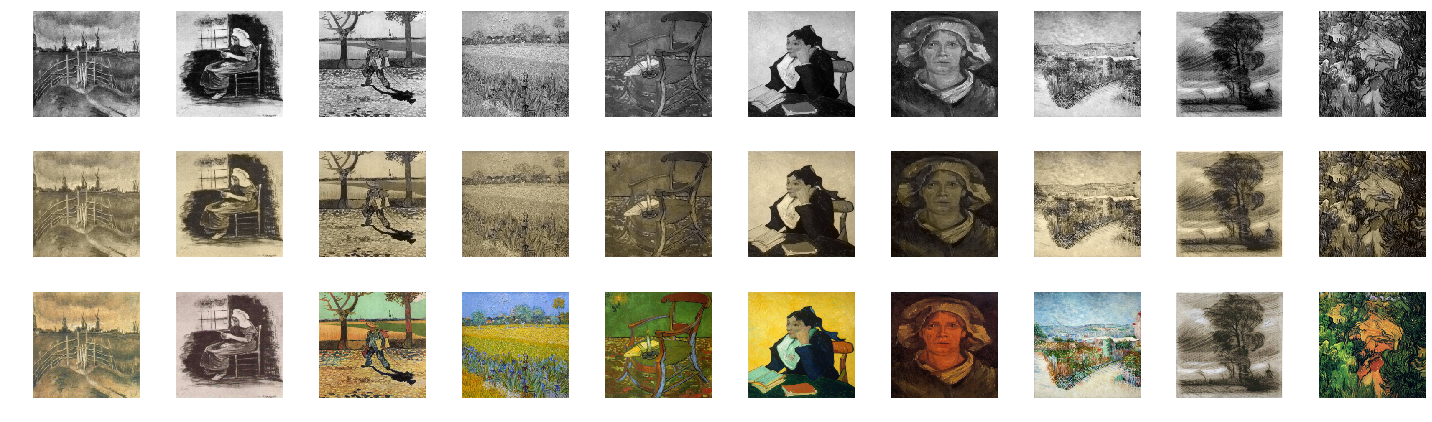

In [52]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # grayscale
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(X_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(X_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()
